In [1]:
import tensorflow as tf
import keras
from keras import layers

tf.random.set_seed(22)

2024-02-20 07:48:36.856923: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-20 07:48:37.346031: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 07:48:37.346076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 07:48:37.450226: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 07:48:37.661959: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-20 07:48:37.664281: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
import json
import numpy as np
import pandas as pd
from time import time
import random
import matplotlib.pyplot as plt
import os

In [4]:
name_model = "RWMDMA-MP50-NB"
with open("../examples/rez.json", "r") as f:
    dataset = json.load(f)

In [5]:
print("Первый x:\n", dataset["x"][0])
print("Последний, x:\n", dataset["x"][-1])
print("Размер x:\t", len(dataset["x"][0]))
print("Первый y:\t", dataset["y"][0])
print("Последний y:\t", dataset["y"][0])
print("Кол-во записей:\t", len(dataset["x"]))

Первый x:
 [15.0, 1.0, 18.027756377319946, 2.0, 0.24253562503633297, 1.0, 0.0, 0.9984603532054125, 15.0, 1.0, 18.027756377319946, 2.0, 0.24253562503633297, 1.0, 0.0, 0.9984603532054125, 15.0, 1.0, 18.027756377319946, 2.0, 0.24253562503633297, 1.0, 0.0, 0.9984603532054125, 15.0, 1.0, 18.027756377319946, 2.0, 0.24253562503633297, 1.0, 0.0, 0.9984603532054125, 15.0, 1.0, 18.027756377319946, 2.0, 0.24253562503633297, 1.0, 0.0, 0.9984603532054125, 15.0, 1.0, 18.027756377319946, 2.0, 0.24253562503633297, 1.0, 0.0, 0.9984603532054125, 15.0, 1.0, 18.027756377319946, 2.0, 0.24253562503633297, 1.0, 0.0, 0.9984603532054125, 15.0, 1.0, 18.027756377319946, 2.0, 0.24253562503633297, 1.0, 0.0, 0.9984603532054125, 15.0, 1.0, 18.027756377319946, 2.0, 0.24253562503633297, 1.0, 0.0, 0.9984603532054125, 15.0, 1.0, 18.027756377319946, 2.0, 0.24253562503633297, 1.0, 0.0, 0.9984603532054125, 15.0, 1.0, 18.027756377319946, 2.0, 0.24253562503633297, 1.0, 0.0, 0.9984603532054125, 15.0, 1.0, 18.027756377319946, 

In [149]:
def shuffle(x_arrays, y_arrays):
    x_vec = np.concatenate(x_arrays)
    y_vec = np.concatenate(y_arrays)
    data = [(x, y) for x, y in zip(x_vec, y_vec)]
    random.shuffle(data)
    x_vec_rnd = np.array([x for x, y in data])
    y_vec_rnd = np.array([y for x, y in data])
    return x_vec_rnd, y_vec_rnd
    

def get_data(dataset, balans=True): #, batch_size=128

    X = np.array(dataset["x"])
    y = np.array(dataset["y"])
    
    keys = np.unique(y)
    Y_keys = dict()
    for i, key in enumerate(keys):
        z = np.zeros(5)
        z[i] = 1
        Y_keys[key] = z
    Y = np.array([Y_keys[yi] for yi in y])

    X_clus_list = []
    Y_clus_list = []

    for i, item in enumerate(Y_keys.keys()):
        X_clus_list.append(X[Y[:,i]==1,:])
        Y_clus_list.append(Y[Y[:,i]==1,:])
        
    if balans:
        balans_len = [len(yc) for yc in Y_clus_list]
        min_len = min(balans_len)
    
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    val_x = []
    val_y = []
    for class_data in zip(X_clus_list, Y_clus_list):
        data = [(x, y) for x, y in zip(class_data[0], class_data[1])]
        random.shuffle(data)
        if balans:
            data = data[:min_len]
        len_data = len(data)
        len_test = round(0.2*len_data)
        len_val = round((len_data-len_test)*0.2)
        len_train = len_data - len_test - len_val
        
        train_x.append([x for x, y in data[:len_train]])
        train_y.append([y for x, y in data[:len_train]])
        
        val_x.append([x for x, y in data[len_train:len_train+len_val]])
        val_y.append([y for x, y in data[len_train:len_train+len_val]])
    
        test_x.append([x for x, y in data[-len_test:]])
        test_y.append([y for x, y in data[-len_test:]])
        
    train_x, train_y = shuffle(train_x, train_y)
    val_x, val_y = shuffle(val_x, val_y)
    test_x, test_y = shuffle(test_x, test_y)
    
    return train_x, train_y, val_x, val_y, test_x, test_y, Y_keys
    

In [150]:
train_x, train_y, val_x, val_y, test_x, test_y, Y_keys = get_data(dataset, balans=True)

In [151]:
y = train_y

class_weights = dict()

for key in Y_keys:
    class_weights[key] = len(y[y[:, key] == 1, :])
print(class_weights)
min_len = min( [w for k, w in class_weights.items()]) 

for key, w in class_weights.items():
    class_weights[key] = w/min_len
print(class_weights)

{0: 629, 1: 629, 2: 629, 3: 629, 4: 629}
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


In [158]:
hist = []
model = keras.Sequential()

input_len = 400
output_len = 5

model.add(layers.Dense(units=input_len, activation='relu'))
model.add(layers.Dense(units=100,  activation='relu'))
model.add(layers.Dropout(rate=0.2, seed=22))
model.add(layers.Dense(units=25,  activation='relu'))
model.add(layers.Dropout(rate=0.2, seed=22))
model.add(layers.Dense(units=20,  activation='relu'))
model.add(layers.Dense(units=output_len, activation='softmax'))

In [159]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [160]:
batch_size = 30
history = model.fit(train_x, train_y, epochs=120, batch_size=batch_size, validation_data=(val_x, val_y))
hist.append(history)

Epoch 1/120
105/105 [==============================] - 1s 4ms/step - loss: 4.0277 - accuracy: 0.2140 - val_loss: 1.6096 - val_accuracy: 0.2025
Epoch 2/120
105/105 [==============================] - 0s 3ms/step - loss: 2.0140 - accuracy: 0.2264 - val_loss: 1.6465 - val_accuracy: 0.2701
Epoch 3/120
105/105 [==============================] - 0s 3ms/step - loss: 1.8369 - accuracy: 0.2413 - val_loss: 1.6066 - val_accuracy: 0.1987
Epoch 4/120
105/105 [==============================] - 0s 3ms/step - loss: 1.6508 - accuracy: 0.2343 - val_loss: 1.6069 - val_accuracy: 0.2000
Epoch 5/120
105/105 [==============================] - 0s 3ms/step - loss: 1.5966 - accuracy: 0.2566 - val_loss: 1.5195 - val_accuracy: 0.3490
Epoch 6/120
105/105 [==============================] - 0s 3ms/step - loss: 1.5661 - accuracy: 0.3056 - val_loss: 1.5179 - val_accuracy: 0.3338
Epoch 7/120
105/105 [==============================] - 0s 3ms/step - loss: 1.6869 - accuracy: 0.3037 - val_loss: 1.4564 - val_accuracy: 0.3732

In [161]:
loss_and_metrics = model.evaluate(test_x, test_y, batch_size=batch_size)
loss_and_metrics

33/33 [==============================] - 0s 1ms/step - loss: 1.1469 - accuracy: 0.5429


[1.1469355821609497, 0.5428571701049805]

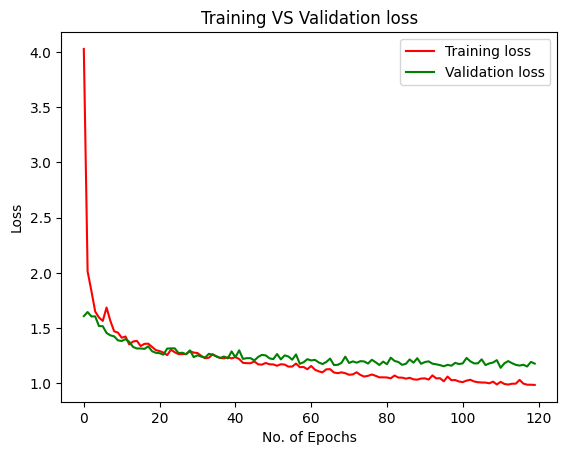

In [162]:
plt.plot(np.concatenate([h.history['loss'] for h in hist]), 'r', label='Training loss')
plt.plot(np.concatenate([h.history['val_loss'] for h in hist]), 'g', label='Validation loss')
plt.title('Training VS Validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

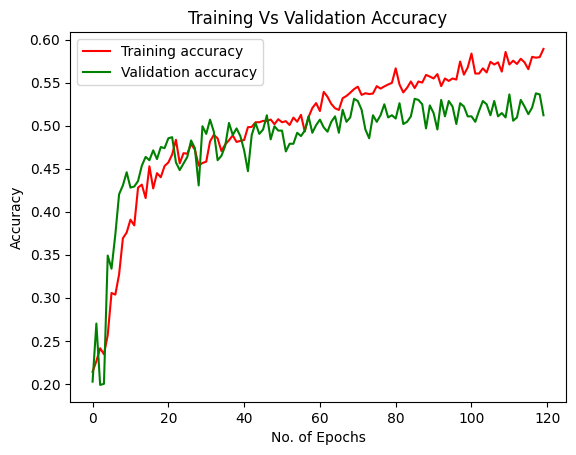

In [163]:
plt.plot(np.concatenate([h.history['accuracy'] for h in hist]), 'r', label='Training accuracy')
plt.plot(np.concatenate([h.history['val_accuracy'] for h in hist]), 'g', label='Validation accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [164]:
class ExportModule(tf.Module):
  def __init__(self, model, preprocess, class_pred):
    # Initialize pre and postprocessing functions
    self.model = model
    self.preprocess = preprocess
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, input_len], dtype=tf.float32)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.preprocess(x)
    y = self.model(x)
    print(y)
    y = self.class_pred(y)
    return y

In [172]:
def preprocess_test(x):
  return x

def class_pred_test(y):
  # Generate class predictions from MLP output
  return y

In [173]:
mlp_model_export = ExportModule(model=model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

In [174]:
save_path = name_model
tf.saved_model.save(mlp_model_export, save_path)
mlp_loaded = tf.saved_model.load(save_path)

Tensor("sequential_15/dense_89/Softmax:0", shape=(None, 5), dtype=float32)
INFO:tensorflow:Assets written to: RWMDMA-MP50-NB/assets


INFO:tensorflow:Assets written to: RWMDMA-MP50-NB/assets


In [175]:
def accuracy_score(y_pred, y):
  # Generic accuracy function
  is_equal = tf.equal(y_pred, y)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

test_classes = mlp_loaded(test_x)
test_acc = accuracy_score([np.argmax(y) for y in test_classes], [np.argmax(y) for y in test_y])
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.543


In [176]:
mlp_loaded(test_x)

<tf.Tensor: shape=(980, 5), dtype=float32, numpy=
array([[1.4182316e-01, 2.3126879e-01, 1.7448731e-02, 3.2943612e-01,
        2.8002328e-01],
       [5.6660748e-01, 8.2528256e-03, 8.9880131e-04, 2.6245570e-02,
        3.9799526e-01],
       [2.7123106e-01, 3.8442924e-03, 4.3228581e-03, 7.1602361e-04,
        7.1988571e-01],
       ...,
       [9.4004792e-01, 1.1038423e-03, 6.1688149e-10, 2.2356475e-03,
        5.6612559e-02],
       [9.9879727e-03, 1.3220030e-01, 7.4812454e-01, 1.0814756e-01,
        1.5396533e-03],
       [6.9349304e-02, 2.0557930e-01, 5.0573552e-01, 1.8056561e-01,
        3.8770318e-02]], dtype=float32)>